In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.io import loadmat
from numpy.linalg import pinv
from scipy.linalg import svdvals
import warnings
warnings.filterwarnings("ignore")

In [2]:
#================== Load data
d = loadmat('ifk.mat', squeeze_me=True)["d"]
d

array([0.2388, 0.2319, 0.2252, 0.2188, 0.2126, 0.2066, 0.2008, 0.1952,
       0.1898, 0.1846, 0.1795, 0.1746, 0.1699, 0.1654, 0.161 , 0.1567,
       0.1526, 0.1486, 0.1447, 0.141 ])

In [3]:
#===================== midpoint and x, y 
a,b = 0, 1
n = 20
delta_x = (b-a)/n
delta_x

x = np.zeros(20)
for j in range(20):
    x[j] = a + delta_x/2 + (j)*delta_x
y = x


#===================== G matrix 
G = np.zeros((20,20))
for i in range(20):
    for j in range(20):
        G[i,j] = delta_x*x[j]*np.exp(-x[j]*y[i])

m = G.shape[0]
n = G.shape[1]

In [4]:
#================ SVD of G
u, s, vh = np.linalg.svd(G, full_matrices= True)
vh = vh.T                
#================ P and null spaces from u, s and vh
p_ = np.linalg.matrix_rank(np.diag(s))
up = u[:, :p_]
vp = vh[:,:p_]
lamp = np.diag(s[:p_])
lamp.shape

#================ Generalized Inverse of G
G_inv = vp@np.linalg.inv(lamp)@up.T

#=============== m-dagger
m_dag = G_inv@d

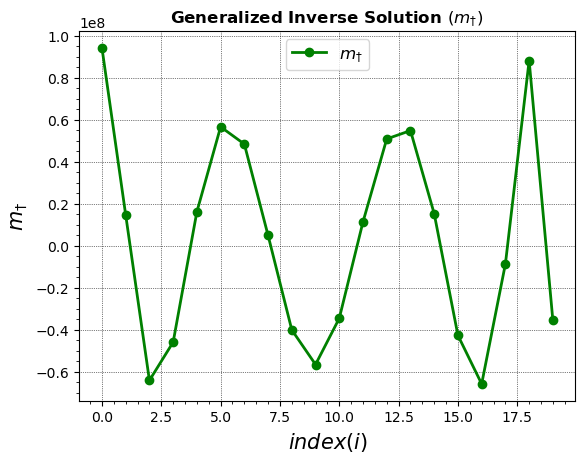

In [25]:
plt.plot(m_dag, marker="o",linewidth=2, c="g",  label=r'$m_{\dagger}$')
plt.legend(fontsize=12)
plt.xlabel('$index(i)$', fontsize=15)
plt.ylabel('$m_{\dagger}$', fontsize=15)
plt.title('Generalized Inverse Solution $(m_{\dagger})$ ',fontweight='bold',fontsize=12)
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()

### Q1) L-curve 

In [40]:
def l_curve_tikh_svd(U, S, d, n_alpha):
    """
    Compute the L-curve for Tikhonov regularization using SVD.
    """
    alphas = np.logspace(-5, 5, n_alpha)
    rho = np.zeros(n_alpha)
    eta = np.zeros(n_alpha)
    for i in range(n_alpha):
        alpha = alphas[i]
        damped_S = S/(S**2 + alpha**2)
        m_alpha = np.dot(U, damped_S * np.dot(U.T, d))
        rho[i] = np.linalg.norm(np.dot(U, m_alpha) - d)
        eta[i] = np.linalg.norm(m_alpha)
    return rho, eta, alphas

def l_curve_corner(rho, eta, alphas):
    """
    Find the corner point of the L-curve.
    """
    x = np.log10(rho)
    y = np.log10(eta)
    dydx = np.diff(y) / np.diff(x)
    d2ydx2 = np.diff(dydx) / np.diff(x[:-1])
    ireg_corner = np.argmax(d2ydx2)
    alpha_corner = alphas[ireg_corner]
    kappa = dydx[ireg_corner]
    return alpha_corner, ireg_corner, kappa

In [41]:
U, S, Vt = np.linalg.svd(G, full_matrices=False)
#================== Compute the L-curve
rho, eta, reg_param = l_curve_tikh_svd(U, S, d, 1000)

#================== Find the corner point of the L-curve
alpha_corner, ireg_corner, kappa = l_curve_corner(rho, eta, reg_param)

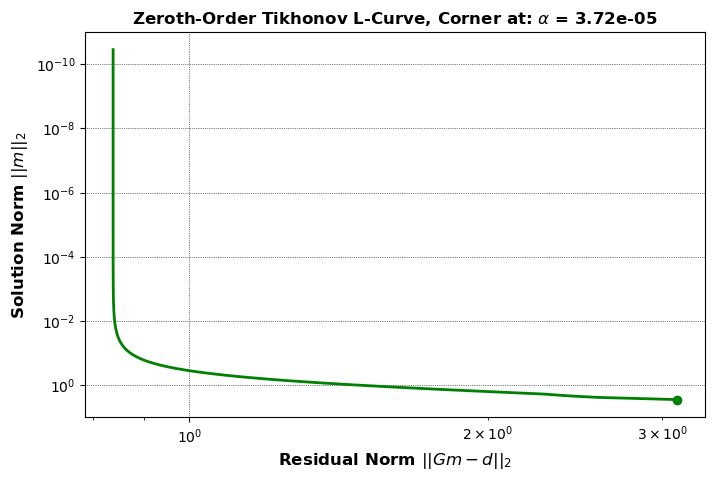

In [42]:
#================== Plot the L-curve and the corner point
plt.figure(figsize=(8,5))
plt.loglog(rho, eta, linewidth=2, c = "g")
plt.loglog(rho[ireg_corner], eta[ireg_corner], 'o', linewidth=2 , c = "g")
plt.gca().invert_yaxis()
plt.xlabel('Residual Norm $||Gm-d||_2$',fontweight='bold', fontsize=12)
plt.ylabel('Solution Norm $||m||_2$',fontweight='bold', fontsize=12)
plt.title('Zeroth-Order Tikhonov L-Curve, Corner at: $\\alpha$ = {:.2e}'.format(alpha_corner),fontweight='bold', fontsize=12)
plt.minorticks_on()
plt.grid(linestyle=':', linewidth=0.5, color='k')
plt.show()

### Q2) Discrepancy

### 2a) 

Noting that our $\chi$ distribution (from assignment 6) was found to have 0 degrees of freedom due to the fact that we have 20 equations and 20 model parameters, we should theoretically be able to obtain a perfect fit to the data. To build realistic models, regularization is required since near precise fits to the data have a tendency to give strange results due to the highly ill conditions. The standard deviation for each measurement was estimated to be 0.0005 given that the data are accurate to four digits after the decimal point.

Applying our rule of thumb, 
\begin{align}
||\mathbf{Gm -d}||_2 \leq \delta \approx \sigma \sqrt{m}
\end{align}

a fair value for $\delta$ is:


In [46]:
#================ Value of delta
sigma = 5**(-4)
delta = sigma*np.sqrt(20)
delta

0.007155417527999328

In [52]:
Gsharp_disc0 = np.linalg.solve(G.T@G + alpha_corner**2*np.eye(20), G.T)
mdisc0 = Gsharp_disc0@d

Text(0.5, 1.0, 'Zeroth-Order Discrepancy Principle Solution (alpha = 3.720236681413066e-05)')

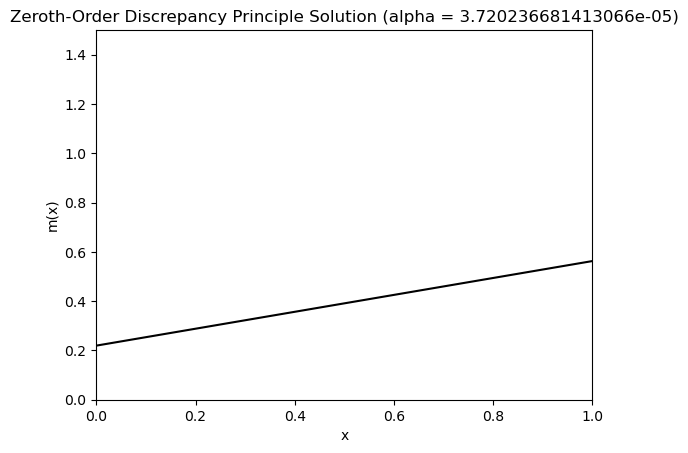

In [55]:
import matplotlib.pyplot as plt

# assuming Gsharp_disc0, G, and mdisc0 are defined
R_disc0 = Gsharp_disc0 @ G
fig, ax = plt.subplots()
ax.plot(mdisc0, color='black')
ax.set_ylim([0, 1.5])
ax.set_xlim([0, 1])
ax.set_xlabel('x')
ax.set_ylabel('m(x)')
ax.set_title('Zeroth-Order Discrepancy Principle Solution (alpha = {})'.format(alpha_corner))


In [53]:
# # import numpy as np
# from scipy.interpolate import interp1d

# # assuming reg_param, rho, delta, and G are defined
# alpha_disc0 = interp1d(rho, reg_param)(delta)
# Gsharp_disc0 = np.linalg.solve(G.T@G + alpha_disc0**2*np.eye(20), G.T)
# mdisc0 = Gsharp_disc0 @ d


In [33]:
alphas = np.logspace(-10, -5, 1000)
alphas

array([1.00000000e-10, 1.01159111e-10, 1.02331658e-10, 1.03517796e-10,
       1.04717682e-10, 1.05931476e-10, 1.07159340e-10, 1.08401436e-10,
       1.09657929e-10, 1.10928986e-10, 1.12214777e-10, 1.13515471e-10,
       1.14831241e-10, 1.16162263e-10, 1.17508713e-10, 1.18870770e-10,
       1.20248614e-10, 1.21642429e-10, 1.23052400e-10, 1.24478715e-10,
       1.25921561e-10, 1.27381132e-10, 1.28857621e-10, 1.30351224e-10,
       1.31862140e-10, 1.33390569e-10, 1.34936714e-10, 1.36500781e-10,
       1.38082977e-10, 1.39683512e-10, 1.41302599e-10, 1.42940453e-10,
       1.44597292e-10, 1.46273336e-10, 1.47968806e-10, 1.49683929e-10,
       1.51418933e-10, 1.53174046e-10, 1.54949504e-10, 1.56745541e-10,
       1.58562396e-10, 1.60400311e-10, 1.62259529e-10, 1.64140297e-10,
       1.66042866e-10, 1.67967487e-10, 1.69914417e-10, 1.71883914e-10,
       1.73876240e-10, 1.75891659e-10, 1.77930439e-10, 1.79992851e-10,
       1.82079168e-10, 1.84189668e-10, 1.86324631e-10, 1.88484341e-10,
      